# Facial Recognition with Principal Components Analysis and Support Vector Machines

This notebook will walk you through a simple facial recognition module.  The notebook is modelled off the [example from scikit-learn](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html) documentation.

In [1]:
# LIBRARIES
print __doc__

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


## Data Preprocessing

The dataset used in this example is a preprocessed excerpt of the ["Labeled Faces in the Wild"](http://vis-www.cs.umass.edu/lfw/), which can be downloaded here: [Full Download (233MB)](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz).  The `fetch_lfw_people` function below makes use of the scikit-learn codebase to handle this dataset for you.

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


2017-04-27 15:54:16,531 Loading LFW people faces from /Users/justinfung/scikit_learn_data/lfw_home


In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### TEST/TRAIN SPLIT

Split the data into training set and test set.

In [4]:
# Split into a training and testing set
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42)

print "training samples: %d" % X_train.shape[0]
print "test samples: %d" % X_test.shape[0]

training samples: 966
test samples: 322


### DECOMPOSITION: PRINCIPAL COMPONENTS ANALYSIS

We obtain the set of PCA vectors by analyzing all training examples.  We then project the input for all faces into the dimensionally-reduced space.

In [5]:
# Compute a PCA (eigenfaces) on the face dataset
n_components = 250

print "Extracting the top %d eigenfaces from %d faces..." % (n_components, X_train.shape[0])
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print "Done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis..."
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "Done in %0.3fs" % (time() - t0)

Extracting the top 250 eigenfaces from 966 faces...
Done in 0.501s
Projecting the input data on the eigenfaces orthonormal basis...
Done in 0.057s


### CLASSIFICATION OF FACES: SUPPORT VECTOR MACHINES

Once the faces have been decomposed, we can apply a supervised learning technique to the faces for classification.  In this case, we choose a support vector machine with a radial bias function kernel.  For parameterization, we choose to search over values for 'C' and 'gamma'.
The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

In [6]:
# Train a SVM classification model
print "Fitting the classifier to the training set..."
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 29.315s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## EVALUATION OF MODEL

We use a "confusion matrix" that displays precision, recall, and f1 metrics for all classes.  We follow with a qualitative looks at some predictions and their grouth truth labels.

In [7]:
# Quantitative evaluation of the model quality on the test set
print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.127s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.74      0.90      0.81        60
  Donald Rumsfeld       0.80      0.59      0.68        27
    George W Bush       0.91      0.90      0.91       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.80      0.78      0.79        36

      avg / total       0.83      0.83      0.82       322

[[  9   1   1   2   0   0   0]
 [  1  54   2   2   0   1   0]
 [  3   4  16   3   0   0   1]
 [  3   6   1 132   1   1   2]
 [  0   1   0   1  20   0   3]
 [  0   4   0   2   1   7   1]
 [  1   3   0   3   1   0  28]]


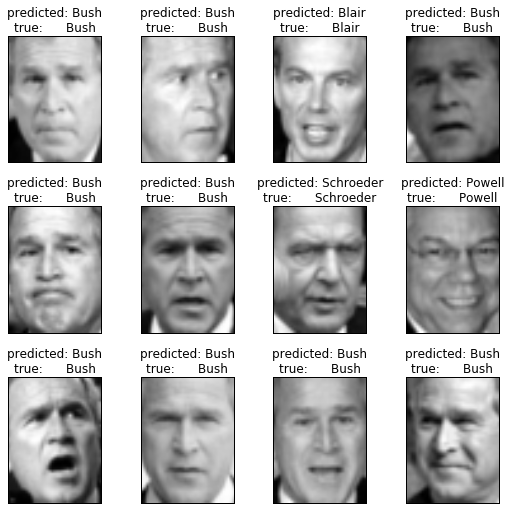

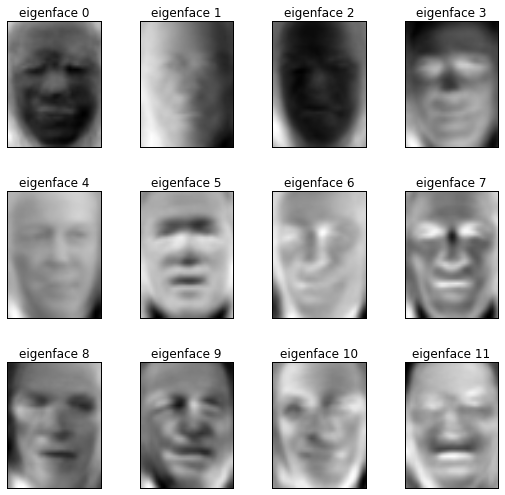

In [8]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()